In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sqlalchemy import create_engine
import time
import logging
import warnings  
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
os.makedirs("logs", exist_ok=True)

In [3]:
logging.basicConfig(
    filename="logs/ingestion_db.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    filemode="a"
)


In [4]:
engine = create_engine("sqlite:///inventory.db")


In [5]:
def ingest_db(df, table_name, engine):
    df.to_sql(table_name, con=engine, if_exists='replace', index=False)

In [6]:
def ingest_db_in_chunks(file_path, table_name, engine, chunksize=100_000):
    first_chunk = True

    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk.to_sql(
            table_name,
            con=engine,
            if_exists="replace" if first_chunk else "append",
            index=False
        )
        first_chunk = False

In [7]:
def load_raw_data():
    start = time.time()

    for file in os.listdir("data"):
        if file.endswith(".csv"):
            file_path = os.path.join("data", file)
            table_name = file[:-4]

            logging.info(f"Starting ingestion for {file}")
            ingest_db_in_chunks(file_path, table_name, engine)
            logging.info(f"Completed ingestion for {file}")

    total_time = (time.time() - start) / 60
    logging.info(f"Ingestion Complete. Total Time: {total_time:.2f} minutes")


if __name__ == "__main__":
    load_raw_data()

In [8]:
conn = sqlite3.connect('inventory.db')

In [9]:
df = pd.read_sql_query("select * from vendor_sales_summary",conn)

In [10]:
df.head(2)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,stockTurnover,SalesPurchaseRation
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5101919.51,672819.31,260999.20,68601.68,1290667.91,25.297693,-3031.0,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4819073.49,561512.37,294438.66,144929.24,1015032.27,21.062810,-3791.0,1.266830


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,1.065065e+04,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,1.803923e+04,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,2.438530e+01,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
ActualPrice,10692.0,3.564367e+01,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
Volume,10692.0,8.473605e+02,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchaseQuantity,10692.0,3.140887e+03,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,3.010669e+04,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesQuantity,10692.0,3.077482e+03,10952.851391,0.00,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesDollars,10692.0,4.223907e+04,167655.265984,0.00,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesPrice,10692.0,1.879378e+04,44952.773386,0.00,289.710000,2857.800000,16059.562500,6.728193e+05


<function matplotlib.pyplot.show(close=None, block=None)>

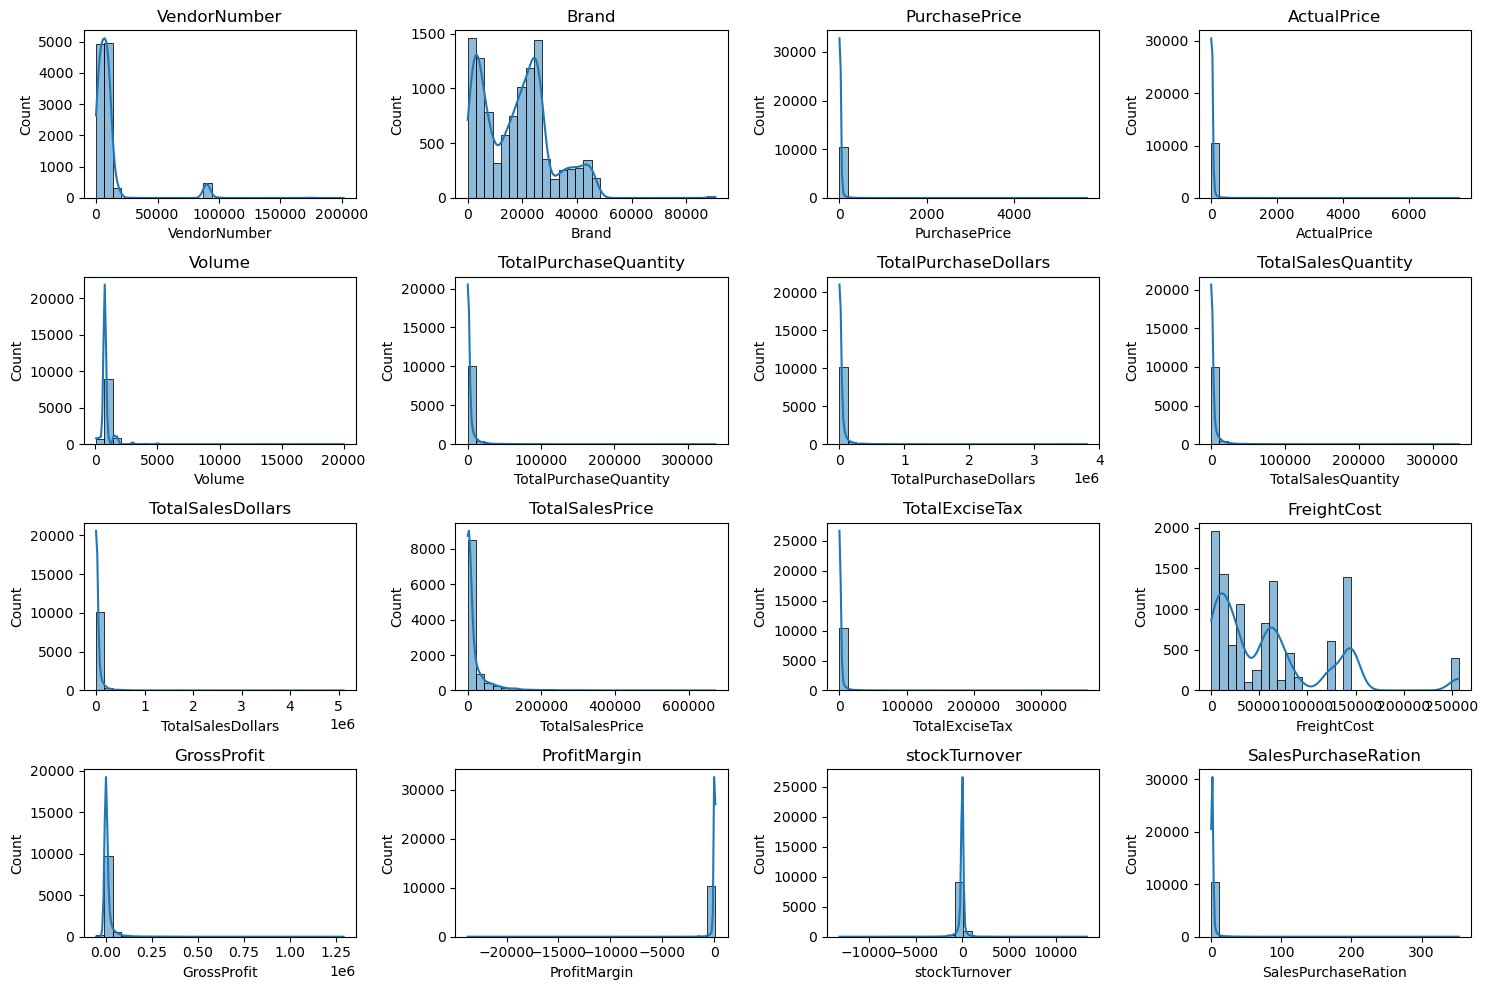

In [12]:
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.show

In [13]:
df = pd.read_sql_query("""SELECT *
FROM vendor_sales_summary
WHERE GrossProfit > 0
AND ProfitMargin > 0
AND TotalSalesQuantity > 0""",conn)

In [14]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,stockTurnover,SalesPurchaseRation
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5101919.51,672819.31,260999.20,68601.68,1290667.91,25.297693,-3031.0,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4819073.49,561512.37,294438.66,144929.24,1015032.27,21.062810,-3791.0,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4538120.60,461140.15,343854.07,123780.22,1119816.92,24.675786,-267.0,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4475972.88,420050.01,368242.80,257032.07,1214774.94,27.139908,-1270.0,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4223107.62,545778.28,249587.83,257032.07,1199901.61,28.412764,-2271.0,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,15.95,10.96,0.55,27100.41,13.31,83.448276,3.0,6.041667
8560,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,65.66,1.47,7.04,50293.62,63.32,96.436186,128.0,28.059829
8561,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,1.98,0.99,0.10,14069.87,0.50,25.252525,0.0,1.337838
8562,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,143.28,77.61,15.12,257032.07,141.81,98.974037,71.0,97.469388


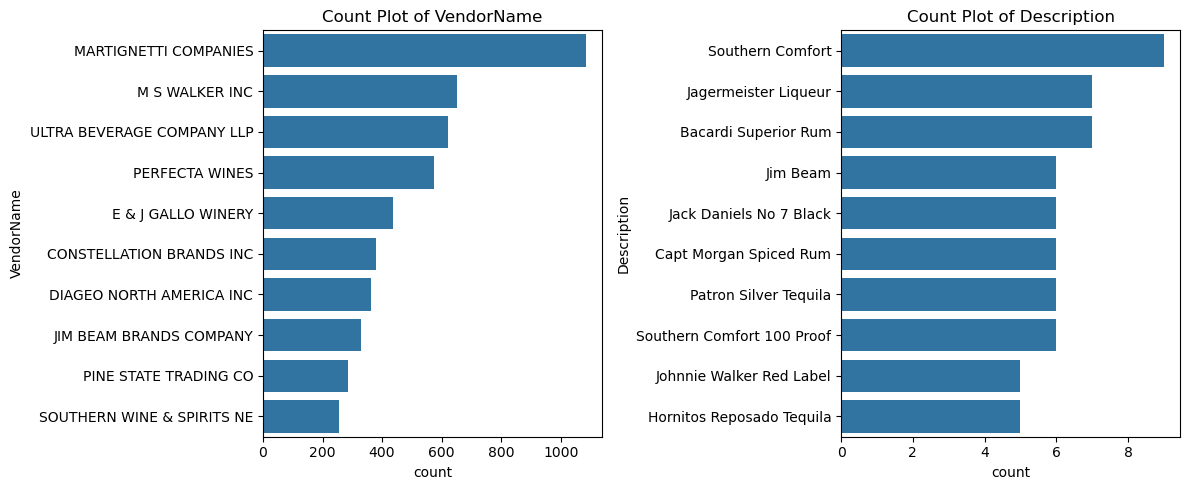

In [15]:
 categorical_cols = ["VendorName","Description"]

plt.figure(figsize=(12,5))
for i , col in enumerate(categorical_cols):
    plt.subplot(1,2,i+1)
    sns.countplot(y=df[col],order=df[col].value_counts().index[:10])
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

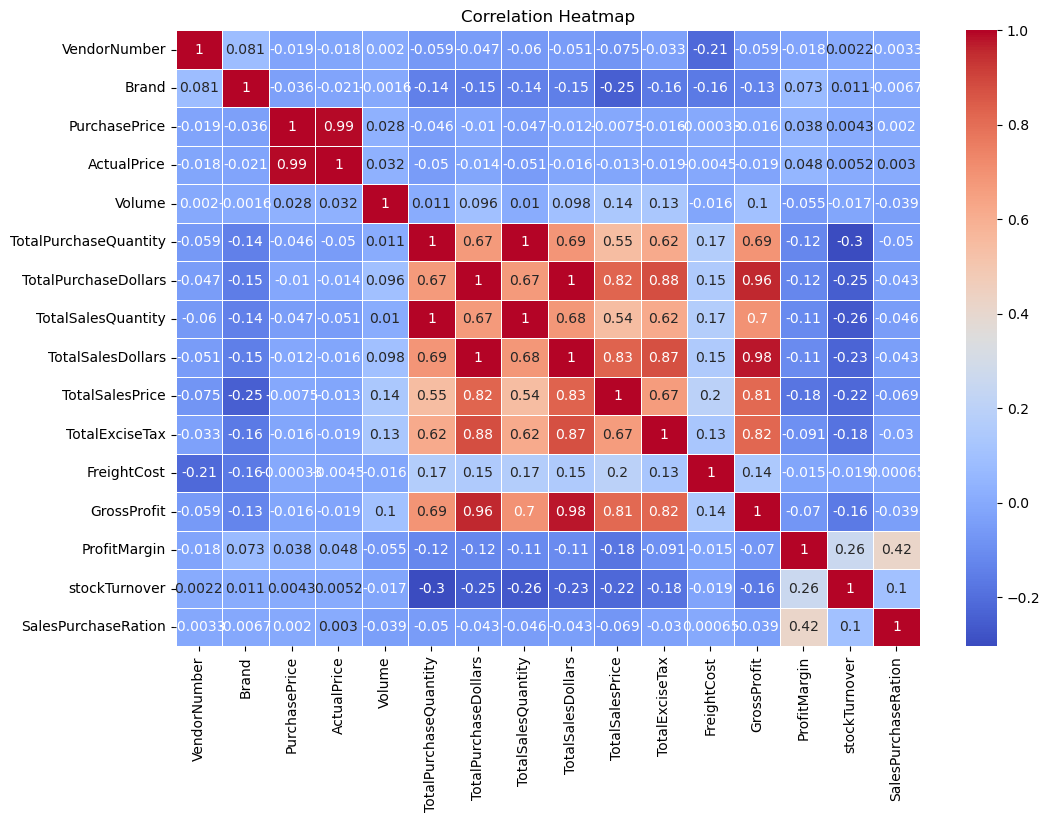

In [16]:
plt.figure(figsize=(12,8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix,annot=True,cmap="coolwarm",linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [17]:
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars':'sum',
    'ProfitMargin':'mean'}).reset_index()

In [18]:
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

In [19]:
low_sales_threshold

np.float64(560.299)

In [20]:
high_margin_threshold

np.float64(64.97017552750113)

In [21]:
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]

print("Brand with Low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))


Brand with Low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


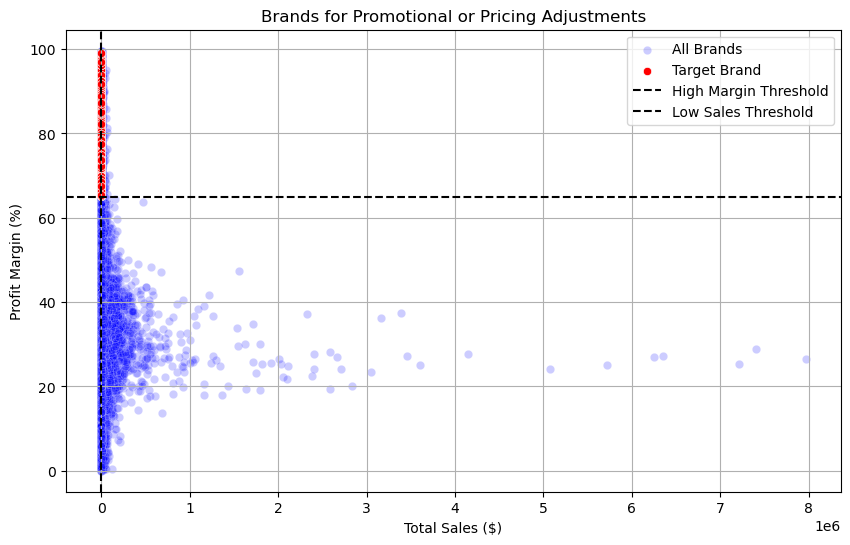

In [22]:


plt.figure(figsize=(10,6))

sns.scatterplot(
    data=brand_performance,
    x='TotalSalesDollars',
    y='ProfitMargin',
    color="blue",
    label="All Brands",
    alpha=0.2
)

sns.scatterplot(
    data=target_brands,
    x='TotalSalesDollars',
    y='ProfitMargin',
    color="red",
    label="Target Brand"
)

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
def formate_dollars(value):
    if value >=1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif value >=1_000:
         return f"{value/1_000:.2f}K"
    else:
         return str(value)

In [25]:
top_vendor = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)
top_vendor

VendorName
DIAGEO NORTH AMERICA INC      67990099.42
MARTIGNETTI COMPANIES         39330359.36
PERNOD RICARD USA             32063196.19
JIM BEAM BRANDS COMPANY       31423020.46
BACARDI USA INC               24854817.14
CONSTELLATION BRANDS INC      24218745.65
E & J GALLO WINERY            18399899.46
BROWN-FORMAN CORP             18247230.65
ULTRA BEVERAGE COMPANY LLP    16502544.31
M S WALKER INC                14706458.51
Name: TotalSalesDollars, dtype: float64

In [26]:
top_brands

Description
Jack Daniels No 7 Black    7964746.76
Tito's Handmade Vodka      7399657.58
Grey Goose Vodka           7209608.06
Capt Morgan Spiced Rum     6356320.62
Absolut 80 Proof           6244752.03
Jameson Irish Whiskey      5715759.69
Ketel One Vodka            5070083.56
Baileys Irish Cream        4150122.07
Kahlua                     3604858.66
Tanqueray                  3456697.90
Name: TotalSalesDollars, dtype: float64

In [27]:
top_brands.apply(lambda x : formate_dollars(x))

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

In [28]:
top_vendor.apply(lambda x :formate_dollars(x))

VendorName
DIAGEO NORTH AMERICA INC      67.99M
MARTIGNETTI COMPANIES         39.33M
PERNOD RICARD USA             32.06M
JIM BEAM BRANDS COMPANY       31.42M
BACARDI USA INC               24.85M
CONSTELLATION BRANDS INC      24.22M
E & J GALLO WINERY            18.40M
BROWN-FORMAN CORP             18.25M
ULTRA BEVERAGE COMPANY LLP    16.50M
M S WALKER INC                14.71M
Name: TotalSalesDollars, dtype: object

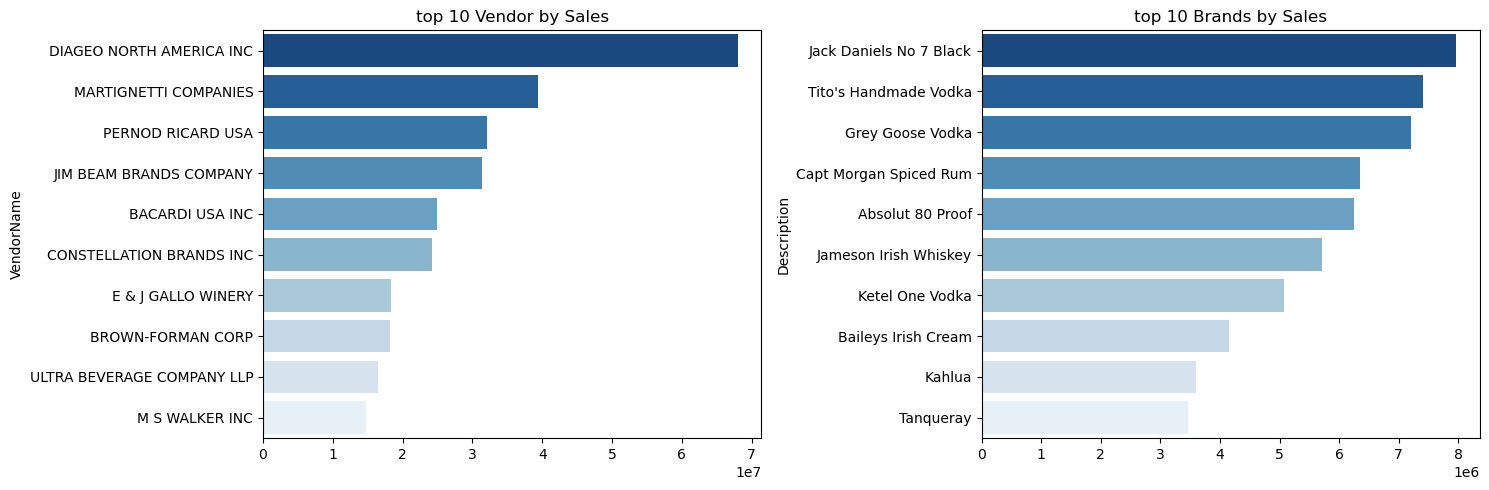

In [29]:
plt.figure(figsize=(15,5))


plt.subplot(1,2,1)
ax1 = sns.barplot(y=top_vendor.index, x=top_vendor.values, palette="Blues_r")
plt.title("top 10 Vendor by Sales")



plt.subplot(1,2,2)
ax1 = sns.barplot(y=top_brands.index, x=top_brands.values, palette="Blues_r")
plt.title("top 10 Brands by Sales")

plt.tight_layout()
plt.show()



In [31]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars':'sum',
    'GrossProfit':'sum',
    'TotalSalesDollars':'sum'
}).reset_index()
vendor_performance.shape

(119, 4)

In [32]:
vendor_performance['PurchaseContribution%'] = vendor_performance['TotalPurchaseDollars']/vendor_performance['TotalPurchaseDollars'].sum()

In [33]:
vendors_performance = round(vendor_performance.sort_values('PurchaseContribution%',ascending =  False),2)

In [34]:
vendors_performance

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
25,DIAGEO NORTH AMERICA INC,50097226.16,17892873.26,67990099.42,0.16
57,MARTIGNETTI COMPANIES,25502095.83,13828263.53,39330359.36,0.08
68,PERNOD RICARD USA,23851164.17,8212032.02,32063196.19,0.08
46,JIM BEAM BRANDS COMPANY,23494304.32,7928716.14,31423020.46,0.08
6,BACARDI USA INC,17432020.26,7422796.88,24854817.14,0.06
...,...,...,...,...,...
33,FANTASY FINE WINES CORP,128.64,198.95,327.59,0.00
107,UNCORKED,118.74,58.20,176.94,0.00
85,SILVER MOUNTAIN CIDERS,77.18,265.33,342.51,0.00
16,CAPSTONE INTERNATIONAL,54.64,192.23,246.87,0.00


In [35]:
top_vendors = vendor_performance.head(10)
top_vendors['TotalsalesDollars'] = top_vendors['TotalSalesDollars'].apply(formate_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(formate_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(formate_dollars)
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%,TotalsalesDollars
0,ADAMBA IMPORTS INTL INC,446.16,258.36999999999995,704.53,0.000001,704.53
1,ALISA CARR BEVERAGES,25.70K,78.77K,104470.94,0.000084,104.47K
2,ALTAMAR BRANDS LLC,11.71K,4.00K,15706.81,0.000038,15.71K
3,AMERICAN SPIRITS EXCHANGE,934.08,577.0799999999998,1511.16,0.000003,1.51K
4,AMERICAN VINTAGE BEVERAGE,104.44K,35.17K,139603.53,0.000340,139.60K
5,ATLANTIC IMPORTING COMPANY,41.12K,18.16K,59272.75,0.000134,59.27K
6,BACARDI USA INC,17.43M,7.42M,24854817.14,0.056719,24.85M
7,BANFI PRODUCTS CORP,1.61M,1.02M,2632085.13,0.005232,2.63M
8,BLACK PRINCE DISTILLERY INC,5.85K,5.75K,11601.20,0.000019,11.60K
9,BLACK ROCK SPIRITS LLC,1.15K,897.0799999999999,2049.18,0.000004,2.05K


In [36]:
top_vendors['Cumulative_Contribution%'] = top_vendors['PurchaseContribution%'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%,TotalsalesDollars,Cumulative_Contribution%
0,ADAMBA IMPORTS INTL INC,446.16,258.36999999999995,704.53,0.000001,704.53,0.000001
1,ALISA CARR BEVERAGES,25.70K,78.77K,104470.94,0.000084,104.47K,0.000085
2,ALTAMAR BRANDS LLC,11.71K,4.00K,15706.81,0.000038,15.71K,0.000123
3,AMERICAN SPIRITS EXCHANGE,934.08,577.0799999999998,1511.16,0.000003,1.51K,0.000126
4,AMERICAN VINTAGE BEVERAGE,104.44K,35.17K,139603.53,0.000340,139.60K,0.000466
5,ATLANTIC IMPORTING COMPANY,41.12K,18.16K,59272.75,0.000134,59.27K,0.000600
6,BACARDI USA INC,17.43M,7.42M,24854817.14,0.056719,24.85M,0.057319
7,BANFI PRODUCTS CORP,1.61M,1.02M,2632085.13,0.005232,2.63M,0.062552
8,BLACK PRINCE DISTILLERY INC,5.85K,5.75K,11601.20,0.000019,11.60K,0.062571
9,BLACK ROCK SPIRITS LLC,1.15K,897.0799999999999,2049.18,0.000004,2.05K,0.062574


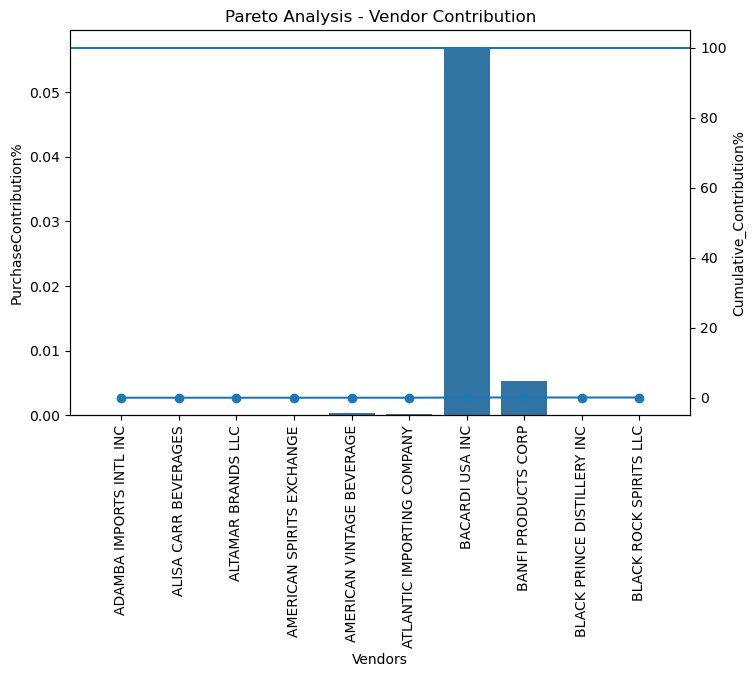

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Figure aur primary axis create kiya
fig, ax1 = plt.subplots(figsize=(8, 5))

# -------------------------
# BAR CHART
# -------------------------
# Vendor ka Purchase Contribution (%) bar chart
sns.barplot(
    x=top_vendors['VendorName'],
    y=top_vendors['PurchaseContribution%'],
    ax=ax1
)

# Y-axis label (Left)
ax1.set_ylabel('PurchaseContribution%')

# X-axis label
ax1.set_xlabel('Vendors')

# Vendor names ko rotate kiya readability ke liye
ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)

# -------------------------
# LINE CHART (CUMULATIVE)
# -------------------------
# Second Y-axis banaya cumulative % ke liye
ax2 = ax1.twinx()

# Cumulative contribution ka line plot
ax2.plot(
    top_vendors['VendorName'],
    top_vendors['Cumulative_Contribution%'],
    marker='o'
)

# Right side Y-axis label
ax2.set_ylabel('Cumulative_Contribution%')

# 100% reference line (Pareto rule samajhne ke liye)
ax2.axhline(100)

# -------------------------
# TITLE
# -------------------------
ax1.set_title('Pareto Analysis - Vendor Contribution')

# Graph show
plt.show()

In [38]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [39]:
df["OrderSize"] =pd.qcut(df["TotalPurchaseQuantity"], q=3 ,labels=["Small","Medium","Large"])

In [40]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,39.068186
Medium,15.486414
Large,10.777625


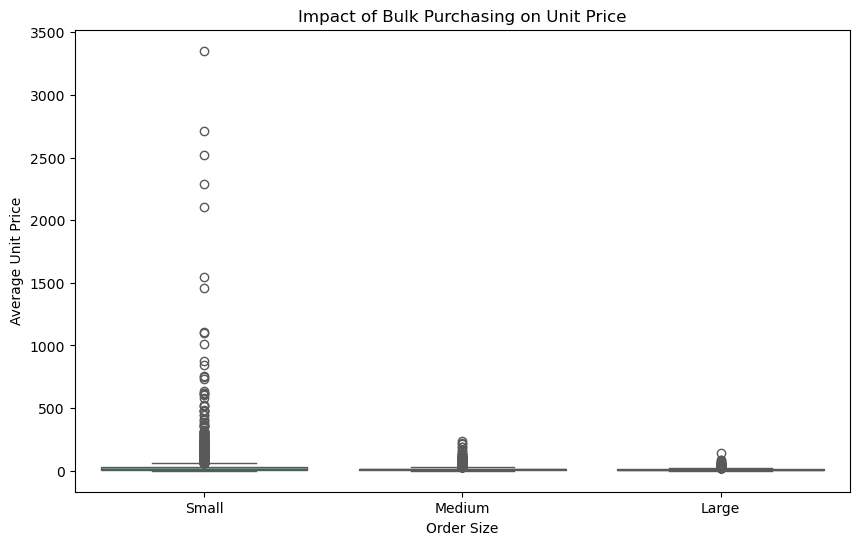

In [41]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Price")
plt.show()

In [ ]:
///which Vendor Have low inventory Turnover///


In [ ]:
df[df['stockTurnover']<1].groupby('VendorName')[['stockTurnover']].mean().sort_values('stockTurnover', ascending=True).head(10)

In [ ]:
df.head(2)

In [42]:
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]
print('Total Unsold Capital:',formate_dollars(df["UnsoldInventoryValue"].sum()))

Total Unsold Capital: 2.71M


In [43]:
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue",ascending=False)

inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue']
inventory_value_per_vendor.head(10)

,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722209.05
46,JIM BEAM BRANDS COMPANY,554665.63
68,PERNOD RICARD USA,470625.61
116,WILLIAM GRANT & SONS INC,401960.83
30,E & J GALLO WINERY,228282.61
79,SAZERAC CO INC,198436.41
11,BROWN-FORMAN CORP,177733.74
20,CONSTELLATION BRANDS INC,133617.62
61,MOET HENNESSY USA INC,126477.70
77,REMY COINTREAU USA INC,118598.15


In [44]:
df =pd.read_sql_query("select * from vendor_sales_summary",conn)

In [45]:
df.head(2)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,stockTurnover,SalesPurchaseRation
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5101919.51,672819.31,260999.20,68601.68,1290667.91,25.297693,-3031.0,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4819073.49,561512.37,294438.66,144929.24,1015032.27,21.062810,-3791.0,1.266830


In [24]:
df.to_csv("data/VendorPerformanceAnalysis.csv",index=False)

print("CSV file created successfully")

CSV file created successfully


In [25]:
df.to_excel("data/VendorPerformanceAnalysis.xlsx",index=False)

print("xlsx file created successfully")

xlsx file created successfully
